In [1]:
 from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
pip install --upgrade tensorflow

     |████████████████████████████████| 394.3MB 40kB/s 
     |████████████████████████████████| 471kB 56.8MB/s 
     |████████████████████████████████| 10.6MB 40.4MB/s 
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import pandas as pd #for high level data structure and data analysis tools
import string #for string manipulations
import numpy as np #for array processing, matrix operations
from numpy import array
import glob #for fast matching of pathnames to directories
from sklearn.model_selection import train_test_split #for using ML methods, build models
from keras.preprocessing import image #for building deep learning models
from PIL import Image #for image processing
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from pickle import dump, load #for converting python objects to byte streams
from time import time #for using time related methods
import pickle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt #for visual representation
import json #for python dictionaries
!pip3 install tensorflow==1.14
!pip3 install -q gpt_2_simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

  Using cached https://files.pythonhosted.org/packages/f4/28/96efba1a516cdacc2e2d6d081f699c001d414cc8ca3250e6d59ae657eb2b/tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


AttributeError: ignored

In [ ]:
from google.colab import files

In [ ]:
gpt2.download_gpt2(model_name='345M' ) #downloading GTP2 model having 345 million features

Fetching checkpoint: 1.05Mit [00:00, 256Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 78.4Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 379Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:20, 68.0Mit/s]                                 
Fetching model.ckpt.index: 1.05Mit [00:00, 272Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 128Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 143Mit/s]                                                       


In [ ]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1') #copying checkpoint of the model

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1') #loading of GPT2

Loading checkpoint checkpoint/run1/model-3500
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-3500


In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299)) # Convert all the images to size 299x299 as expected by the inception v3 model
    x = image.img_to_array(img) # Convert PIL image to numpy array of 3-dimensions
    x = np.expand_dims(x, axis=0) # Add one more dimension
    x = preprocess_input(x) # preprocess the images using preprocess_input() from inception module
    return x

In [ ]:
model = InceptionV3(weights= 'imagenet') # Load the inception v3 model
model_new = Model(model.input, model.layers[-2].output) # Create a new model, by removing the last layer (output layer) and dense layer from the inception v3



96116736/96112376 [==============================] - 3s 0us/step


In [ ]:
def encode(image): # Function to encode a given image into a vector of size (2048, )
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding feature vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
with open('/content/drive/My Drive/Project major/project/data.json', 'r') as f:
    wordtoix = json.load(f) #loading json file as python dictionary

In [ ]:
ixtoword = {v: k for k, v in wordtoix.items()}
vocab_size = len(ixtoword.keys()) +1
max_length = 74

In [ ]:
#load glove vetors
embeddings_index = {} # empty dictionary
f = open('/content/drive/My Drive/Project major/project/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1) #rectified linear unit, output = 0 if input = 0, else output = input
outputs = Dense(vocab_size, activation='softmax')(decoder2) #converts numbers to fit between 0 and 1
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False #so that weights in dictionary file don't change

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop forever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
model.load_weights('/content/drive/My Drive/Project major/project/model_30.h5') #loading gutenberg dataset of 30 books

In [ ]:
def textSearch(photo): #function to predict caption
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0) #text prediction
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final) #final caption
    return final

In [ ]:
def captioning(path_image): #function to encode image and call textSearch()
    image = encode(path_image)
    img = plt.imread(path_image)
    plt.imshow(img)
    x = image.reshape((1,2048))
    return textSearch(x)

In [ ]:
def story_generator(path): #function to generate story
    text = captioning(path)
    return gpt2.generate(sess,
              length=500,
              temperature=0.9,
              prefix=text,
              nsamples=1,
              batch_size=1,
              top_k=20,
              include_prefix=True,
              ) 

man in blue shirt and sunglasses is standing in front of building ,
with a red cape on his back and is leaning against it 
Oh, dear, he says, I have no cloak and jacket  It is a secret,
but it would be a pleasure to talk with you 
You, eh? says Mr  Danglars 
Ah, yes, yes; a good day's work, he repeats   Why, Mr Danglars,
you know you are going to do the same thing 
Oh, my dear fellow he answers 
Then I shall be delighted, says Danglars 
Well, you know I shall, says the young man, who is not very tall,
and who is very thin, but I shall get on well, and I wish it all the
sameto get better and faster than you 
Mr  Danglars is going into town in the morning  He has been
visiting the theatre on Monday morning; he is the first to come;
he is the only person at the door, so you will be sure to see him at
the theatre at half past two oclock  Now, I have a letter from him,
and that letter was delivered to Mr  Villefort, who is the president of
the Academy, but he is a very clever man, and his l

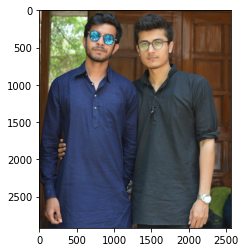

In [ ]:
story_generator('/content/drive/My Drive/Project major/project/testPic1.jpg')

man in blue shirt and jeans is walking down the street with one of his dogs
off to the side, but there isn't a dog in sight, but the sun is
bright  So he starts at the top, walking backwards towards it  It seems to be
a very long way down, but he hasn't made it  Then he starts at the
second level, and when he reaches it, he stops to pick up some stones 
The stone is there, but it has nothing to do with the stone he dropped
on the ground, and when he comes back he finds the stones in the way,
and he says to himself, Why, it was all he had to do to get this thing
out  He runs home, gets his dog, and goes straight to the top  Then he
comes back and finds a stone, but the stone isn't there; it is the top
of a house, and there isn't even a dog in the house  So he goes back down 
He runs home and finds something else there, but it isn't there  He
runs again and finds something bigger, but it is nowhere near his
goal  So he runs back home, finds the top and runs to it, and there
is a whole vi

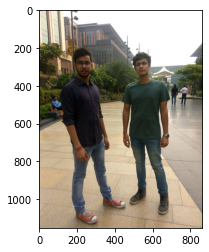

In [ ]:
story_generator('/content/drive/My Drive/Project major/project/testPic3.jpg')

dog is jumping in the air
and crying  When I see him, he is in such a rage, the whole
house is filled with the noise of his cries  He is on the floor,
there is a large pile of clothes strewn about, and the dog is
tied up so tightly, that I am afraid he will get his throat cut 
You are quite right, said the poor fellow 
I am quite right, said the landlord, and I think I shall be obliged
to keep him  I have no business with them 
Do you think I am obliged to take him away?
You would have it so 
Ah, but what do I care? He is my friend 
The landlord took the dog away, and then, turning to
the landlord, said, I will go and tell Miss Havisham and Miss
Harmon to come and see him in the morning 
The poor fellow came to her in great distress 
It is not my business, said she; but if Miss Havisham and Miss
Harmon come, and if I tell Miss Havisham and Miss Harmon, then
what shall I be to the dogs?
Well, said the landlord, I should not be able to help you, but
I dare say I could keep your poor dog,

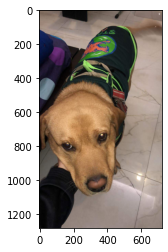

In [ ]:
story_generator('/content/drive/My Drive/Project major/project/testPic4.jpg')

group of people are riding bicycles in the street
at a distance of about two or three hundred paces    
So the young man, who was riding on the opposite side of the path,
came up to see what the young man was doing   It was not possible to
see what was going on with the old man, as he was riding on the opposite
side of the pathway   So, at last, he reached the path leading from the
street to the house of the barons   It was about a quarter of a mile
away   The young man and the old man were seated on the steps   The
baron had his hat on the back of his head, and he was looking down on
the young man and the baron   At the time when he was looking down upon
them, the young man was leaning forward on his stick, and the old man was
leaning forward 
    _I_ wish to know, baron, whether you will be willing to
give up your claim by taking your claim, or whether you will not
offer it   _Do_ you offer it? said the young man   _Do_
you offer it? asked the baron   _Do_ you offer it? said the baro

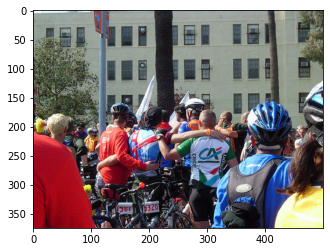

In [ ]:
story_generator('/content/drive/My Drive/Project major/project/testPic5.jpg')

In [ ]:
def uploader():
    uploaded = files.upload()
    pat = '/content/' + str(list(uploaded.keys())[0])
    story_generator(pat)

Saving Annotation 2020-03-06 011257.png to Annotation 2020-03-06 011257.png
x after img_to_array [[[ 79.  35.  26.]
  [ 83.  39.  30.]
  [ 83.  39.  28.]
  ...
  [ 86.  46.  46.]
  [ 88.  48.  48.]
  [ 87.  47.  47.]]

 [[ 76.  31.  25.]
  [ 83.  38.  32.]
  [ 82.  37.  31.]
  ...
  [ 84.  46.  45.]
  [ 86.  48.  47.]
  [ 83.  47.  47.]]

 [[ 78.  33.  27.]
  [ 84.  39.  33.]
  [ 83.  38.  32.]
  ...
  [ 83.  44.  45.]
  [ 84.  45.  46.]
  [ 83.  47.  47.]]

 ...

 [[ 68.  40.  39.]
  [ 64.  38.  37.]
  [ 63.  37.  36.]
  ...
  [206. 189. 163.]
  [206. 189. 163.]
  [206. 189. 163.]]

 [[ 66.  38.  37.]
  [ 61.  35.  34.]
  [ 61.  35.  34.]
  ...
  [206. 189. 163.]
  [206. 189. 163.]
  [206. 189. 163.]]

 [[ 66.  38.  37.]
  [ 60.  34.  33.]
  [ 59.  33.  32.]
  ...
  [206. 189. 163.]
  [206. 189. 163.]
  [206. 189. 163.]]]
x after expansion dims [[[[ 79.  35.  26.]
   [ 83.  39.  30.]
   [ 83.  39.  28.]
   ...
   [ 86.  46.  46.]
   [ 88.  48.  48.]
   [ 87.  47.  47.]]

  [[ 76.  31.

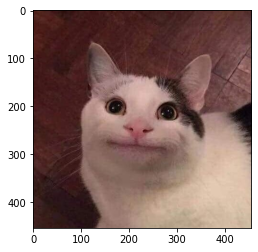

In [ ]:
uploader()